In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from skimage import io

#!pip install efficientnet_pytorch torchtoolbox
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
#import torchtoolbox.transform as transforms

import torchvision
from torchvision import datasets, models, transforms

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import gc
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
def make_CNN(model_name, num_classes):
    # Initialize these variables which will be set in this if statement. Each of these
    # variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # You may NOT use pretrained models!! 
    use_pretrained = False
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, 1)
        input_size = 224
        
    elif model_name == "vgg16":
        """ VGG16_bn
        """
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, 1)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, 1, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, 1)
        input_size = 224
        
    else:
        raise Exception("Invalid model name!")
    
    return model_ft, input_size

In [29]:
class Melanoma_Net(nn.Module):
    """
    fc1: number of neurons in the hidden fully connected layer
    """
    def __init__(self, cnn_model_name, num_classes, num_multimodal_features=9, fc1_out=32):
        #num_classes = 1
        #num_multimodal_features= 9
        super(Melanoma_Net, self).__init__()
        self.cnn, self.input_size = make_CNN(cnn_model_name, num_classes)#models.vgg11(pretrained=False, progress = True)
        #define output layers
        self.fc1 = nn.Linear(num_classes + num_multimodal_features, fc1_out) #takes in input of CNN and multimodal input
        self.fc2 = nn.Linear(fc1_out, num_classes)
        
    def forward(self, image, data):
        x1 = self.cnn(image)
        #print("x1", x1.shape)
        x2 = data
        #print("x2", x2.shape)
        #print("x1: ", x1, type(x1))
        #print("x2: ", x2, type(x2))
        #x = torch.cat((x1, x2), dim=1)  
        x = torch.cat((x1.float(), x2.float()), dim=1) ### ???
        #print("concat", x.shape)
        x = F.relu(self.fc1(x))
        #print("relu", x.shape)
        x = self.fc2(x)
        #print('forward output: ', x)
        #print("fc2", x.shape)
        return x.double() ### ???

In [30]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img_path):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        img = cv2.imread(img_path)
        n_hairs = random.randint(1, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #converts image color back to regular color (instead of producing blue tinted image)        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [31]:
class MultimodalDataset(Dataset):
    """
    Custom dataset definition
    """
    def __init__(self, csv_path, img_path, mode='train', transform=None):
        """
        """
        self.df = pd.read_csv(csv_path)
        self.img_path = img_path
        self.mode= mode
        self.transform = transform
        
            
    def __getitem__(self, index):
        """
        """
        img_name = self.df.iloc[index]["image_name"] + ".jpg"
        img_path = os.path.join(self.img_path, img_name)
        image = Image.open(img_path)

        dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor # ???
        
        if self.mode == 'train':
            #augments malignant images with hair twice
            if self.df.iloc[index]["augmented"]==1:
                image = AdvancedHairAugmentation(hairs_folder="../input/melanoma-hairs")(img_path)
                image = Image.fromarray(image, 'RGB')
            elif self.df.iloc[index]["augmented"]==2:
                image = AdvancedHairAugmentation(hairs_folder="../input/melanoma-hairs")(img_path)
                image = Image.fromarray(image, 'RGB')
            else:  
                image = image.convert("RGB")
                
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels = torch.tensor(self.df.iloc[index]["target"], dtype = torch.float64)
            
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, labels
            
        elif self.mode == 'val':
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            labels = torch.tensor(self.df.iloc[index]["target"], dtype = torch.float64)
            
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, labels
        
        else: #when self.mode=='test'
            image = np.asarray(image)
            if self.transform is not None:
                image = self.transform(image)
            features = np.fromstring(self.df.iloc[index]["features"][1:-1], sep=",") #turns features into an array
            features = torch.from_numpy(features.astype("float")) #turns the features array into a vector
            return image, features, self.df.iloc[index]["image_name"]

    def __len__(self):
        return len(self.df)

In [32]:
image_path_dict = {'train': "../input/siim-isic-melanoma-classification/jpeg/train",
                  'val': "../input/siim-isic-melanoma-classification/jpeg/train" ,
                  'test': "../input/siim-isic-melanoma-classification/jpeg/test"}

In [33]:
def get_dataloaders(input_size, batch_size, augment=False, shuffle = True):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    data_transforms = {
        'train': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ]),
        'val': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ]),
        'test': transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.225])
        ])
    }
    # Create training and validation datasets
    data_subsets = {x: MultimodalDataset(csv_path="../input/demofiles/" + x + ".csv", 
                                         img_path = image_path_dict[x],
                                         mode = x,
                                         transform=data_transforms[x]) for x in data_transforms.keys()}
    
    # Create training and validation dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: DataLoader(data_subsets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

In [34]:
def train_model(model, dataloaders, criterion, optimizer, 
                scheduler, model_name=str(datetime.datetime.now()), 
                save_dir = None, num_epochs=25):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys 
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights 
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found, 
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()

    val_acc_history = []
    
    #take out if just starting to train
    checkpoint = torch.load("../input/resnet-weights-15/resnet_weights_15.pt")
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch_before = checkpoint['epoch']
    
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            val_pred = []
            train_pred = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, features, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                features = features.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs, features)
                    outputs = torch.squeeze(outputs)
                    labels = torch.squeeze(labels)
                    #print("model outputs: ", outputs, outputs.size())
                    #print("model labels: ", labels.size())
                    loss = criterion(outputs, labels)

                    # torch.max outputs the maximum value, and its index
                    # Since the input is batched, we take the max along axis 1
                    # (the meaningful outputs)
                    # print("outputs: ", outputs)
                    preds = (outputs > 0).type(torch.float64)
                    
                    # backprop + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        train_pred.append(preds)
                        
                    if phase == 'val':
                        val_pred.append(preds)
                #statistics
                #print("loss: ", loss.item())
                #print("inputs: ", inputs.size(0), inputs.size())
                
                running_loss += loss.item() * inputs.size(0)
                #print("running loss: ", running_loss)
                running_corrects += torch.sum(preds == labels.data)
                #print("running corrects: ", running_corrects)
                
            #print("train_pred", train_pred)    
            #print("val_pred", val_pred)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            #is the accuracy calculated correctly?
            #print("running_corrects: ", running_corrects.double(), running_corrects.size())
            #print("dataloaders len: ", len(dataloaders[phase].dataset))
            
            epoch_acc = 100* running_corrects.double() / (len(dataloaders[phase].dataset))
            epoch_acc = epoch_acc.item()

            print('{} Loss: {:.4f} Acc: {:.4f}%'.format(phase, epoch_loss, epoch_acc))
            
            #copy the model
            if phase == 'val':
                model_file = { 'epoch': epoch + epoch_before + 1,
                      'state_dict': model.state_dict(),
                      'optimizer' : optimizer.state_dict()}
                torch.save(model_file, "{}_weights_{}.pt".format(model_name, epoch + epoch_before+1))
                #epoch if just started training
                #epoch + epoch_before + 1 afterwards
                val_acc_history.append(epoch_acc)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                
        print()
        scheduler.step()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Val Acc: {:4f}'.format(best_acc))

    #load best model weights
    #return model, val_acc_history

In [35]:
def make_optimizer(model):
    #Get all the parameters
    params_to_update = model.parameters()
    print("Params to learn:")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    #Use SGD
    optimizer = optim.SGD(params_to_update, lr=0.01, momentum=0.9)
    return optimizer

def get_loss(num_classes,device):
    #Create an instance of the loss function
    #We could set weights to account for unbalanced data but we have augmented the data to be even in benign count and malignant count
    
    pos_weight = torch.tensor(np.ones(num_classes)) #### TODO for other class numbers
    pos_weight = pos_weight.to(device)

    criterion = nn.BCEWithLogitsLoss()
    return criterion

In [36]:
# Models to choose from [resnet, vgg16, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = 'resnet'

# Number of classes in the dataset
num_classes = 1

# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 32

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 1

#Directory to save weights to
#save_dir = "weights"
#os.makedirs(save_dir, exist_ok=True)

In [37]:
gc.collect()

104

In [38]:
# Initialize the model for this run
model = Melanoma_Net(cnn_model_name = model_name, num_classes = num_classes)
input_size = model.input_size
    
dataloaders = get_dataloaders(input_size, batch_size, shuffle = shuffle_datasets)
criterion = get_loss(num_classes=num_classes,device=device)

#Move the model to the gpu if needed
model = model.to(device)

optimizer = make_optimizer(model)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10],gamma=0.1)

#Train the model!
#train_model(model=model,
         #   dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
          #  scheduler=scheduler, model_name=model_name, num_epochs=num_epochs)

Params to learn:
	 cnn.conv1.weight
	 cnn.bn1.weight
	 cnn.bn1.bias
	 cnn.layer1.0.conv1.weight
	 cnn.layer1.0.bn1.weight
	 cnn.layer1.0.bn1.bias
	 cnn.layer1.0.conv2.weight
	 cnn.layer1.0.bn2.weight
	 cnn.layer1.0.bn2.bias
	 cnn.layer1.1.conv1.weight
	 cnn.layer1.1.bn1.weight
	 cnn.layer1.1.bn1.bias
	 cnn.layer1.1.conv2.weight
	 cnn.layer1.1.bn2.weight
	 cnn.layer1.1.bn2.bias
	 cnn.layer2.0.conv1.weight
	 cnn.layer2.0.bn1.weight
	 cnn.layer2.0.bn1.bias
	 cnn.layer2.0.conv2.weight
	 cnn.layer2.0.bn2.weight
	 cnn.layer2.0.bn2.bias
	 cnn.layer2.0.downsample.0.weight
	 cnn.layer2.0.downsample.1.weight
	 cnn.layer2.0.downsample.1.bias
	 cnn.layer2.1.conv1.weight
	 cnn.layer2.1.bn1.weight
	 cnn.layer2.1.bn1.bias
	 cnn.layer2.1.conv2.weight
	 cnn.layer2.1.bn2.weight
	 cnn.layer2.1.bn2.bias
	 cnn.layer3.0.conv1.weight
	 cnn.layer3.0.bn1.weight
	 cnn.layer3.0.bn1.bias
	 cnn.layer3.0.conv2.weight
	 cnn.layer3.0.bn2.weight
	 cnn.layer3.0.bn2.bias
	 cnn.layer3.0.downsample.0.weight
	 cnn.layer3.0

In [39]:
model = Melanoma_Net(cnn_model_name = model_name, num_classes = num_classes) 
checkpoint = torch.load('../input/meta-resnet-model-for-colab/resnet_weights_15.pt') 
model.load_state_dict(checkpoint['state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_size = model.input_size 
dataloaders = get_dataloaders(input_size, batch_size, shuffle = shuffle_datasets) 
test_loader = dataloaders['test']

if torch.cuda.is_available(): model.cuda()
    
model.eval()

fn_list = [] 
pred_list = []

for inputs, features, fn in test_loader: 
    inputs = inputs.to(device) 
    features = features.to(device) 
    output = model(inputs, features) 
    pred = (output > 0).type(torch.float64) 
    fn_list += fn 
    pred_list += [p.item() for p in pred]

In [40]:
def showimage(image_name):
    image_path = "../input/siim-isic-melanoma-classification/jpeg/test/" + image_name + ".jpg"
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)


In [41]:
def results(predicted):
    if predicted == 0:
        classification = "benign"
    else:
        classification = "malignant"
    print("Our model predicted your skin lesion to be " + classification + ".")
    if(classification == "benign"):
        print("We recommend you still see a dermatologist to be safe, but it is likely that your lesion is noncancerous.")
    else:
        print("We recommend you schedule an appointment with a dermatologist so that you can receive the proper care as soon as possible, in the case of true malignancy.")

In [42]:

image_name = fn_list[25]
predicted = pred_list[25]

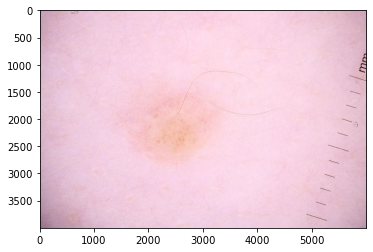

In [43]:
showimage(image_name)

In [44]:
results(predicted)

Our model predicted your skin lesion to be benign.
We recommend you still see a dermatologist to be safe, but it is likely that your lesion is noncancerous.


In [45]:
image_name = fn_list[8]
predicted = pred_list[8]

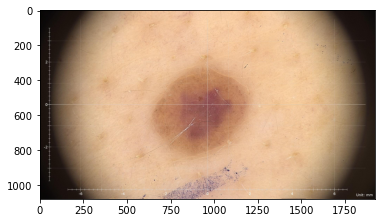

In [46]:
showimage(image_name)

In [47]:
results(predicted)

Our model predicted your skin lesion to be malignant.
We recommend you schedule an appointment with a dermatologist so that you can receive the proper care as soon as possible, in the case of true malignancy.
